## Refine epithelial cell annotations for large intestine - relabelling uncertain cells based on manual inspection/majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [164]:
sns.set_style(style="white")
sns.set_context(context="paper")

### Import

In [5]:
#import data
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Epi.pooled_disease_with_klennerman_ramnik.log1pcounts.20230221.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 311277 × 18485
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [7]:
list(adata.obs.organ_unified.unique())

['ileum',
 'caecum',
 'rectum',
 'sigmoid colon',
 'colon',
 'ascending colon',
 'small intestine',
 'stomach',
 'descending colon',
 'transverse',
 'duodenum']

In [8]:
#remove large intestine and stomach samples
adata = adata[adata.obs.organ_unified.isin(['ileum',
 
 'small intestine',
 'duodenum'])].copy()

In [9]:
adata

AnnData object with n_obs × n_vars = 165793 × 18485
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [10]:
#import scanvi coordinates
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Epi_SI_adult_method2_20230221_RAMNIK_KLENERMAN_POOLED_scANVIobsm_TApooled.csv.gz',compression='gzip',index_col=0)

In [11]:
adata_scanvi

LV1       LV2       LV3  \
index                                                                    
AAAGATGAGTCCAGGA-4918STDY7273964          0.106777 -1.581919  0.953797   
AAAGATGTCTAACTTC-4918STDY7273964         -0.326288 -1.232465  0.075656   
AAAGCAATCTTGTCAT-4918STDY7273964         -0.206530 -0.884726  0.887867   
AAAGTAGAGAATGTTG-4918STDY7273964          0.674783 -1.860157  0.311393   
AAAGTAGAGTCCAGGA-4918STDY7273964          0.326591 -1.331011  0.892378   
...                                            ...       ...       ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX  1.126156 -1.603150 -1.321975   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX  1.429793  0.794451 -0.054200   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX  0.276539 -3.302082 -0.301166   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX -1.029690 -0.465764 -0.886426   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX  1.529757 -0.017395 -0.224238   

                                               LV4       LV5       LV6  \
index                                                                    
AAAGATGAGTCCAGGA-4918STDY7273964          0.244733  0.150768 -0.013615   
AAAGATGTCTAACTTC-4918STDY7273964          0.489752  0.118587 -0.031781   
AAAGCAATCTTGTCAT-4918STDY7273964          0.531088  0.085285  0.053983   
AAAGTAGAGAATGTTG-4918STDY7273964          1.353063  0.095522  0.023743   
AAAGTAGAGTCCAGGA-4918STDY7273964          1.304705  0.120355  0.138660   
...                                            ...       ...       ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX -1.465220  0.030367 -0.090218   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX  0.303938 -0.004205  0.125666   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX -0.014363  0.031501  0.022452   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX  0.727670  0.015594  0.145017   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX -0.084586  0.042973  0.003435   

                                               LV7       LV8       LV9  \
index                                                                    
AAAGATGAGTCCAGGA-4918STDY7273964          0.126867 -0.056913  1.644769   
AAAGATGTCTAACTTC-4918STDY7273964         -0.025199  0.007295 -1.474205   
AAAGCAATCTTGTCAT-4918STDY7273964          0.057822 -0.096761 -0.067910   
AAAGTAGAGAATGTTG-4918STDY7273964          0.058249 -0.038614 -0.709768   
AAAGTAGAGTCCAGGA-4918STDY7273964          0.115567 -0.089768  1.343268   
...                                            ...       ...       ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX -0.090023  0.085183 -1.068241   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX  0.060234 -0.244193  0.038551   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX  0.071834  0.159822 -1.545251   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX -0.033797 -0.102954 -0.773130   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX  0.026321 -0.160082 -0.684138   

                                              LV10      LV11      LV12  \
index                                                                    
AAAGATGAGTCCAGGA-4918STDY7273964         -0.037695 -0.037948 -2.552821   
AAAGATGTCTAACTTC-4918STDY7273964         -0.006849  0.006761 -2.182468   
AAAGCAATCTTGTCAT-4918STDY7273964         -0.031125 -0.016919 -2.596084   
AAAGTAGAGAATGTTG-4918STDY7273964         -0.016771 -0.030022 -2.739576   
AAAGTAGAGTCCAGGA-4918STDY7273964         -0.103557  0.006986 -2.304565   
...                                            ...       ...       ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX  0.034061 -0.009418 -0.549896   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX  0.011738 -0.006313 -0.609832   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX -0.042196  0.003208 -3.664826   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX  0.028818  0.009299 -0.006245   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX -0.012004  0.060460 -2.207342   

                                              LV13      LV14      LV15  \
index                                                                    
AAAGATGAGTCCAGGA-4918STDY7273964          0.504

In [12]:
adata.obsm['X_scANVI'] = adata_scanvi

In [13]:
#import metadata
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Epi_SI_adult_method2_20230221_RAMNIK_KLENERMAN_POOLED_TApooled.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (3,5,6,8,9,11,12,14,64,66,67,69,72,76,77,78,80,82,85,86,87,88,89,94,97,99,100,102,103,105,106,107,108,109,110,111,112,113,115) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
adata_meta

latent_cell_probability  \
index                                                               
AAAGATGAGTCCAGGA-4918STDY7273964                         0.999885   
AAAGATGTCTAACTTC-4918STDY7273964                         0.999927   
AAAGCAATCTTGTCAT-4918STDY7273964                         0.999758   
AAAGTAGAGAATGTTG-4918STDY7273964                         0.999979   
AAAGTAGAGTCCAGGA-4918STDY7273964                         0.999440   
...                                                           ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                      NaN   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX                      NaN   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                      NaN   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX                      NaN   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX                      NaN   

                                          latent_RT_efficiency  \
index                                                            
AAAGATGAGTCCAGGA-4918STDY7273964                      2.082940   
AAAGATGTCTAACTTC-4918STDY7273964                      3.495316   
AAAGCAATCTTGTCAT-4918STDY7273964                      1.737549   
AAAGTAGAGAATGTTG-4918STDY7273964                      4.830041   
AAAGTAGAGTCCAGGA-4918STDY7273964                      1.066133   
...                                                        ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX                   NaN   

                                           cecilia22_predH  \
index                                                        
AAAGATGAGTCCAGGA-4918STDY7273964          Epithelial cells   
AAAGATGTCTAACTTC-4918STDY7273964          Epithelial cells   
AAAGCAATCTTGTCAT-4918STDY7273964                   B cells   
AAAGTAGAGAATGTTG-4918STDY7273964          Epithelial cells   
AAAGTAGAGTCCAGGA-4918STDY7273964          Epithelial cells   
...                                                    ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX               NaN   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX               NaN   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX               NaN   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX               NaN   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX               NaN   

                                          cecilia22_predH_prob  \
index                                                            
AAAGATGAGTCCAGGA-4918STDY7273964                      0.999849   
AAAGATGTCTAACTTC-4918STDY7273964                      0.307406   
AAAGCAATCTTGTCAT-4918STDY7273964                      0.802323   
AAAGTAGAGAATGTTG-4918STDY7273964                      0.992046   
AAAGTAGAGTCCAGGA-4918STDY7273964                      0.624124   
...                                                        ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX                   NaN   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX                   NaN   

                                         cecilia22_predH_uncertain  \
index                                                                
AAAGATGAGTCCAGGA-4918STDY7273964                  Epithelial cells   
AAAGATGTCTAACTTC-4918STDY7273964                  Epithelial cells   
AAAGCAATCTTGTCAT-4918STDY7273964                           B cells   
AAAGTAGAGAATGTTG-4918STDY7273964                  Epithelial cells   
AAAGTAGAGTCCAGGA-4918STDY7273964                  Epithelial cells   
...                                                            ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                   

In [15]:
adata.obs = adata_meta

In [16]:
adata.obs.donor_disease.unique()

array(['PIBD', 'CD', 'control', nan], dtype=object)

In [17]:
#fix metadata
adata.obs['disease'] = adata.obs['donor_category'].astype(str) + '_' + adata.obs['donor_disease'].astype(str)

In [18]:
list(adata.obs.disease.unique())

['disease_PIBD',
 'disease_CD',
 'control_CD',
 'control_control',
 'control_nan',
 'celiac_active_nan',
 'celiac_treated_nan']

In [19]:
adata.obs['donor_disease'] = (adata.obs['disease'].map(lambda x:{
'control_control':'control',
 'control_CD':'CD',
 'disease_PIBD':'PIBD',
 'disease_cancer':'cancer',
 'disease_CD':'CD',
 'control_nan':'control',
 'celiac_active_nan':'celiac_active',
 'celiac_treated_nan':'celiac_treated'
    
    }.get(x,x)).astype("category"))

In [20]:
adata.obs.donor_disease.unique()

['PIBD', 'CD', 'control', 'celiac_active', 'celiac_treated']
Categories (5, object): ['CD', 'PIBD', 'celiac_active', 'celiac_treated', 'control']

In [21]:
adata.obs['disease'] = (adata.obs['disease'].map(lambda x:{
'control_control':'control',
 'control_CD':'control',
 'disease_PIBD':'pediatric_IBD',
 'disease_cancer':'cancer_colorectal',
 'disease_CD':'crohns_disease',
 'control_nan':'control',
 'celiac_active_nan':'celiac_active',
 'celiac_treated_nan':'celiac_treated'
    
    }.get(x,x)).astype("category"))

In [22]:
list(adata.obs.disease.unique())

['pediatric_IBD',
 'crohns_disease',
 'control',
 'celiac_active',
 'celiac_treated']

In [23]:
adata.obs['level3_annot'] = adata.obs.fine_predicted_labels

### Process

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


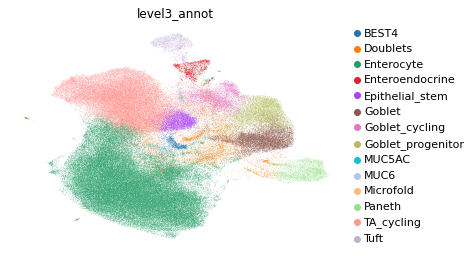

In [24]:
#compute neighbours and umap
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['level3_annot'])

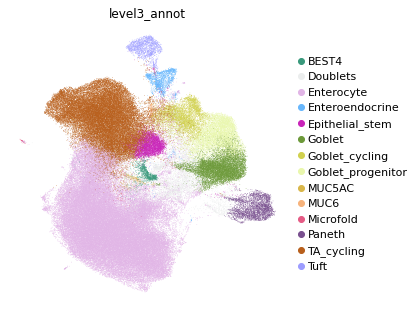

In [25]:
#plot umaps
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='level3_annot',palette = ['#39997c',#BEST4
                                                 
                                               #'#d66245',#Colonocyte
                                               #'#9c6b73',#DSC_MUC17
                                               #'#99216b',#DSC_MUC17 cycling
                                                 '#ebeded',#doublets
                                               '#e1b5e6',#enterocyte
                                                '#68b7fc',#enteroendocrine
                                               '#c924b9',#stem
                                               '#6c9939',#goblet
                                               '#d1d14f',#goblet_cycling
                                               '#e9f7ad',#goblet progenitor
                                               
                                               #'#fa6161',#late colonocyte
                                              '#d9b74a',#MUC5AC
                                               '#f7b37c',#MUC6
                                               
                                               '#e55b85',#Microfold
                                               '#79508f',#paneth
                                              #'#ad1a55',#TA
                                               '#b85f1c',#TA cycling
                                               '#9d9dff',#tuft
                                               
                                               
    
    
                                              ],size=1.5,save='_epi_pooled_disease_SI_level3annot.png')

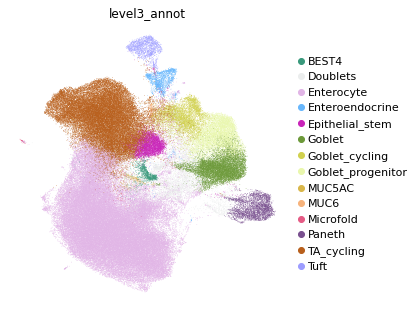

In [26]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='level3_annot',palette = ['#39997c',#BEST4
                                                 
                                               #'#d66245',#Colonocyte
                                               #'#9c6b73',#DSC_MUC17
                                               #'#99216b',#DSC_MUC17 cycling
                                                 '#ebeded',#doublets
                                               '#e1b5e6',#enterocyte
                                                '#68b7fc',#enteroendocrine
                                               '#c924b9',#stem
                                               '#6c9939',#goblet
                                               '#d1d14f',#goblet_cycling
                                               '#e9f7ad',#goblet progenitor
                                               
                                               #'#fa6161',#late colonocyte
                                              '#d9b74a',#MUC5AC
                                               '#f7b37c',#MUC6
                                               
                                               '#e55b85',#Microfold
                                               '#79508f',#paneth
                                              #'#ad1a55',#TA
                                               '#b85f1c',#TA cycling
                                               '#9d9dff',#tuft
                                               
                                               
    
    
                                              ],size=1.5,save='_epi_pooled_disease_SI_level3annot.pdf')

In [27]:
adata.obs['organ_unified'].cat.categories

Index(['duodenum', 'ileum', 'small intestine'], dtype='object')

In [28]:
adata.obs['organ_unified'].cat.reorder_categories(['duodenum','ileum','small intestine'], inplace=True)

<ipython-input-28-e582009687f8>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['organ_unified'].cat.reorder_categories(['duodenum','ileum','small intestine'], inplace=True)


/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


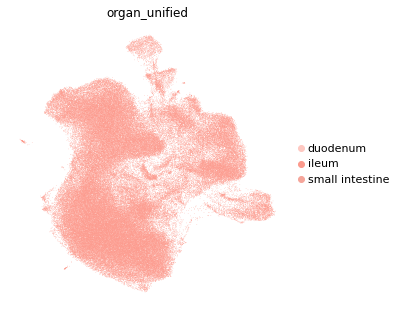

In [29]:
c_organs_unified = [
     
     '#fec8c1', #duodenum
     '#fc9a8d',#ileum
     '#f5a59a', #small intestine
    ]
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata, color='organ_unified',palette=c_organs_unified,save='_organ_pooled_disease_SI.png',size=1.2)

In [30]:
adata.obs['disease'].cat.categories

Index(['celiac_active', 'celiac_treated', 'control', 'crohns_disease',
       'pediatric_IBD'],
      dtype='object')

In [31]:
adata.obs['disease'].cat.reorder_categories(['control',
 'crohns_disease',
 'pediatric_IBD','celiac_active','celiac_treated'], inplace=True)

<ipython-input-31-912bdeba3687>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['disease'].cat.reorder_categories(['control',


/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


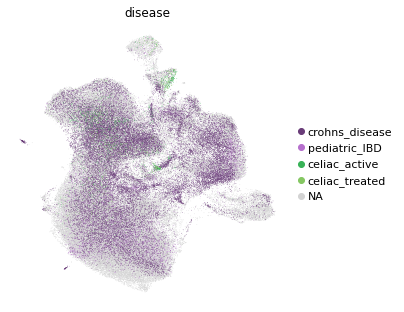

In [32]:
sc.pl.umap(adata,color = 'disease',palette=['#ADD3DD',#control
                                    '#693C78',#crohn's disease
                                            #'#8934B1',#UC
                                            '#B670CD',#PIBD
                                            #'#1C0B86',#colorectal cancer
                                            '#38B257',#celiac_active
                                            '#85C762',#celiac_inactive
                                           ],groups=['crohns_disease',
 'ulcerative_colitis',
 'pediatric_IBD',
 'cancer_colorectal','celiac_active','celiac_treated'],size=1.5,save='pooled_healthy_SI_disease.png')

In [33]:
adata.layers['counts'] = adata.X

In [34]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [247]:
marker_genes_dict = { 'BEST4':['BEST4','CA7','GUCA2B','CFTR'],
                     'Colonocyte':['CA1','GPT'],
                     'DCS_MUC17':['MUC17','TFF1','CD55','TM4SF1','DUOX2','DUOXA2'],
                        'Enterocyte':['FABP1','APOA4','PRAP1','PCK1','RBP2','SI'],
                     'Enteroendocrine':['CHGA','PCSK1N','SCT','SCGN','NEUROD1'],
                     'Stem':['LGR5','RGMB','ASCL2','OLFM4'],
                     'Cycling markers':['MKI67','PCNA','TOP2A'],
                     
                     'Goblet':['MUC2','TFF3','FCGBP','ZG16'],
                      'Goblet_progenitor':['SOX4'],
                      'MUC5AC':['MUC5AC','GKN2'],
                     'MUC6':['MUC6','AQP5','BPIFB1','PGC'],
                     'Microfold':['IL2RG','ICAM2','CCL20','CCL23'],
                     'Paneth':['DEFA6','DEFA5','REG3A','PLA2G2A'],
                     
                     'Tuft':['SH2D6','LRMP','MATK','HPGDS']
                     }

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


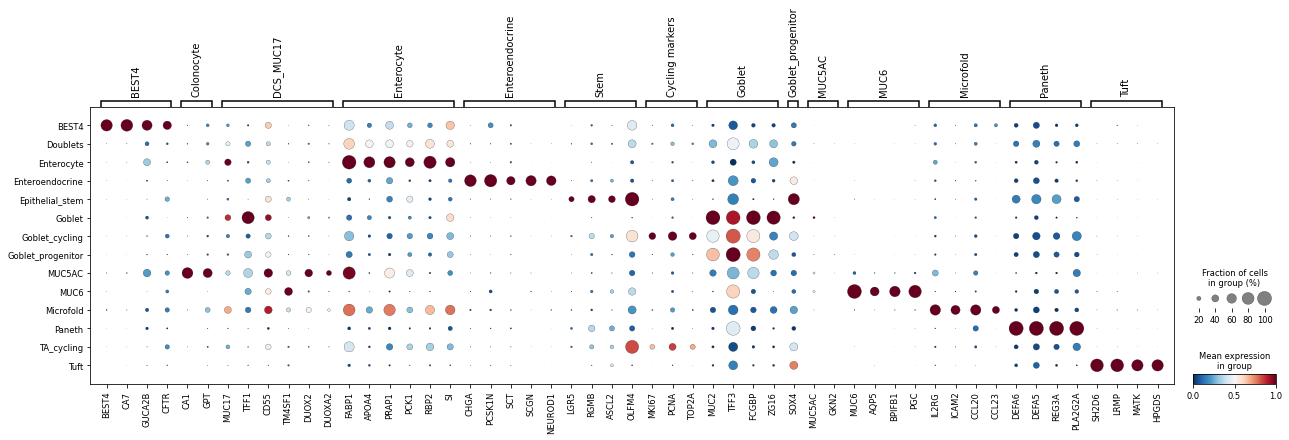

In [36]:
#plot markers
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var',save='_epi_SI_pooled_disease_markergenes.png')

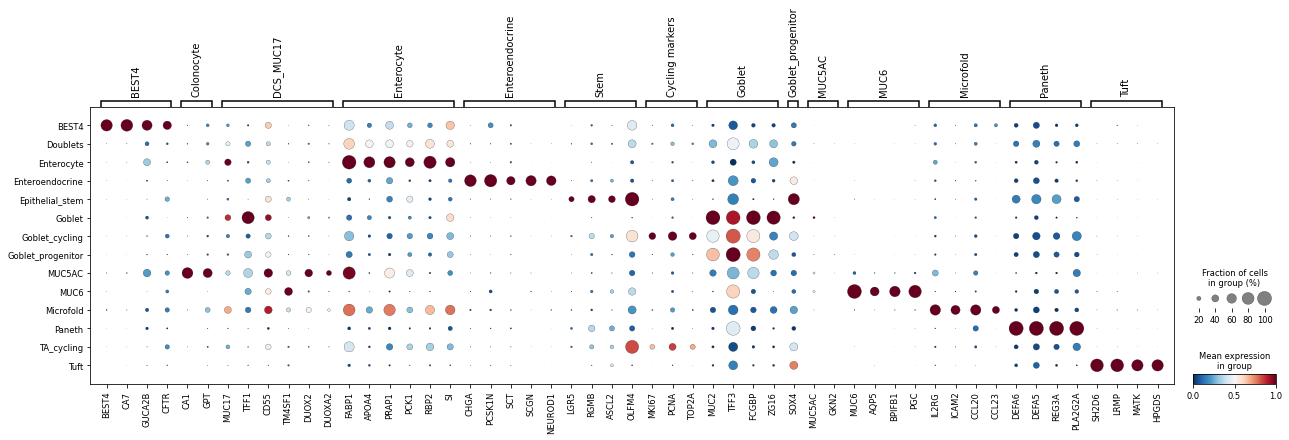

In [38]:
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var',save='_epi_SI_pooled_disease_markergenes.pdf')

### Define uncertain cells

In [39]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [40]:
uncert

fine_predicted_labels  \
index                                                            
AAAGATGAGTCCAGGA-4918STDY7273964                Goblet_cycling   
AAAGATGTCTAACTTC-4918STDY7273964                    TA_cycling   
AAAGCAATCTTGTCAT-4918STDY7273964                    TA_cycling   
AAAGTAGAGAATGTTG-4918STDY7273964                Goblet_cycling   
AAAGTAGAGTCCAGGA-4918STDY7273964             Goblet_progenitor   
...                                                        ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX       Enteroendocrine   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX            Enterocyte   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX       Enteroendocrine   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX            Enterocyte   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX            TA_cycling   

                                          fine_predicted_labels_uncertainty  
index                                                                        
AAAGATGAGTCCAGGA-4918STDY7273964                               5.999911e-02  
AAAGATGTCTAACTTC-4918STDY7273964                               5.960464e-08  
AAAGCAATCTTGTCAT-4918STDY7273964                               1.999623e-02  
AAAGTAGAGAATGTTG-4918STDY7273964                               3.800201e-01  
AAAGTAGAGTCCAGGA-4918STDY7273964                               3.995941e-01  
...                                                                     ...  
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                       0.000000e+00  
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX                       2.000485e-01  
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                       5.990762e-01  
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX                       2.800021e-01  
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX                       1.998407e-02  

[165793 rows x 2 columns]

In [45]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.379987895488739


(array([8.1815e+04, 1.1512e+04, 8.0640e+03, 1.1251e+04, 4.3210e+03,
        3.8380e+03, 3.4690e+03, 6.0950e+03, 2.7800e+03, 2.4690e+03,
        2.3840e+03, 4.3840e+03, 2.0800e+03, 2.0000e+03, 3.3640e+03,
        2.2830e+03, 1.8710e+03, 1.8980e+03, 3.6990e+03, 1.7200e+03,
        1.0920e+03, 8.3300e+02, 1.1890e+03, 4.0900e+02, 3.4300e+02,
        2.2900e+02, 2.5700e+02, 7.7000e+01, 4.3000e+01, 2.4000e+01]),
 array([0.        , 0.02533517, 0.05067034, 0.07600551, 0.10134068,
        0.12667585, 0.15201102, 0.1773462 , 0.20268137, 0.22801654,
        0.25335171, 0.27868688, 0.30402205, 0.32935722, 0.35469239,
        0.38002756, 0.40536273, 0.4306979 , 0.45603307, 0.48136825,
        0.50670342, 0.53203859, 0.55737376, 0.58270893, 0.6080441 ,
        0.63337927, 0.65871444, 0.68404961, 0.70938478, 0.73471995,
        0.76005512]),
 <BarContainer object of 30 artists>)

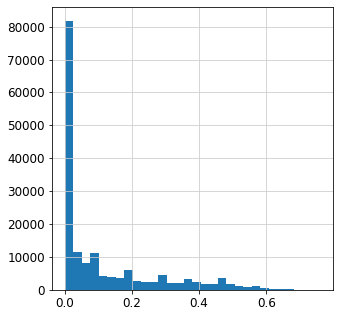

In [59]:
#plot uncertainty distribution
plt.hist(uncert['fine_predicted_labels_uncertainty'], bins=30)

In [42]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-42-564ece27298b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Uncertain (> 0.3)')


### Have a look at other lineages 90th percentile to decide if this should be done per lineage

In [83]:
LI_uncert = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Epi_LI_adult_method2_20230221_RAMNIK_KLENERMAN_POOLED.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (3,5,6,8,9,11,12,14,64,67,69,76,77,78,89,94,97,99,100,102,103,105,106,107,108,109,110,111,112,113) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [84]:
LI_uncert

latent_cell_probability  \
index                                                           
AAACCTGGTCTTTCAT-scrEXT001                           0.999873   
AAAGATGGTATAGGGC-scrEXT001                           0.999923   
AAAGATGGTGGCCCTA-scrEXT001                           0.999929   
AAAGCAAGTAAACACA-scrEXT001                           0.999882   
AAAGCAAGTCATCCCT-scrEXT001                           0.999743   
...                                                       ...   
N130084_L-GTGGTTACAGTTCCAA-N130084_L                      NaN   
N130084_L-TATCCTATCGTTCATT-N130084_L                      NaN   
N130084_L-TCATCCGGTATGATCC-N130084_L                      NaN   
N130084_L-GGTCACGGTTAGCGGA-N130084_L                      NaN   
N130084_L-TGGTGATAGTTGGAAT-N130084_L                      NaN   

                                      latent_RT_efficiency   cecilia22_predH  \
index                                                                          
AAACCTGGTCTTTCAT-scrEXT001                        2.794602  Epithelial cells   
AAAGATGGTATAGGGC-scrEXT001                        3.364700  Epithelial cells   
AAAGATGGTGGCCCTA-scrEXT001                        3.838964  Epithelial cells   
AAAGCAAGTAAACACA-scrEXT001                        3.473178  Epithelial cells   
AAAGCAAGTCATCCCT-scrEXT001                        1.723092  Epithelial cells   
...                                                    ...               ...   
N130084_L-GTGGTTACAGTTCCAA-N130084_L                   NaN               NaN   
N130084_L-TATCCTATCGTTCATT-N130084_L                   NaN               NaN   
N130084_L-TCATCCGGTATGATCC-N130084_L                   NaN               NaN   
N130084_L-GGTCACGGTTAGCGGA-N130084_L                   NaN               NaN   
N130084_L-TGGTGATAGTTGGAAT-N130084_L                   NaN               NaN   

                                      cecilia22_predH_prob  \
index                                                        
AAACCTGGTCTTTCAT-scrEXT001                        0.843226   
AAAGATGGTATAGGGC-scrEXT001                        0.994449   
AAAGATGGTGGCCCTA-scrEXT001                        0.999978   
AAAGCAAGTAAACACA-scrEXT001                        0.221513   
AAAGCAAGTCATCCCT-scrEXT001                        0.117101   
...                                                    ...   
N130084_L-GTGGTTACAGTTCCAA-N130084_L                   NaN   
N130084_L-TATCCTATCGTTCATT-N130084_L                   NaN   
N130084_L-TCATCCGGTATGATCC-N130084_L                   NaN   
N130084_L-GGTCACGGTTAGCGGA-N130084_L                   NaN   
N130084_L-TGGTGATAGTTGGAAT-N130084_L                   NaN   

                                     cecilia22_predH_uncertain  \
index                                                            
AAACCTGGTCTTTCAT-scrEXT001                    Epithelial cells   
AAAGATGGTATAGGGC-scrEXT001                    Epithelial cells   
AAAGATGGTGGCCCTA-scrEXT001                    Epithelial cells   
AAAGCAAGTAAACACA-scrEXT001                           Uncertain   
AAAGCAAGTCATCCCT-scrEXT001                           Uncertain   
...                                                        ...   
N130084_L-GTGGTTACAGTTCCAA-N130084_L                       NaN   
N130084_L-TATCCTATCGTTCATT-N130084_L                       NaN   
N130084_L-TCATCCGGTATGATCC-N130084_L                       NaN   
N130084_L-GGTCACGGTTAGCGGA-N130084_L                       NaN   
N130084_L-TGGTGATAGTTGGAAT-N130084_L                       NaN   

                                       cecilia22_predL  cecilia22_predL_prob  \
index                                                                          
AAACCTGGTCTTTCAT-scrEXT001            Epithelial cells              0.949155   
AAAGATGGTATAGGGC-scrEXT001            Epithelial cells              0.998999   
AAAGATGGTGGCCCTA-scrEXT001            Epithelial cells              0.999997   
AAAGCAAGTAAACACA-scrEXT001            Epithelial cells              0.155091   
AAAGC

#### Also have a look if markedly different between cancer and other diseases

In [85]:
LI_uncert['disease'] = LI_uncert['donor_category'].astype(str) + '_' + LI_uncert['donor_disease'].astype(str)

In [86]:
LI_uncert['disease'].unique()

array(['disease_cancer', 'disease_UC', 'disease_PIBD', 'control_CD',
       'disease_CD', 'control_control'], dtype=object)

In [87]:
LI_uncert['donor_category'].unique()

array(['disease', 'control'], dtype=object)

In [88]:
LI_cancer = LI_uncert[LI_uncert['disease'].isin(['disease_cancer'])]

In [94]:
LI_cancer['disease'].unique()

array(['disease_cancer'], dtype=object)

In [89]:
LI_other = LI_uncert[~LI_uncert['disease'].isin(['disease_cancer'])]

In [96]:
LI_other['disease'].unique()

array(['disease_UC', 'disease_PIBD', 'control_CD', 'disease_CD',
       'control_control'], dtype=object)

In [65]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(LI_uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.46001356934255966


(array([4.2238e+04, 6.3760e+03, 5.1030e+03, 7.7560e+03, 3.2970e+03,
        3.0490e+03, 5.5570e+03, 2.5800e+03, 2.4760e+03, 2.9150e+03,
        3.9520e+03, 2.2270e+03, 2.2360e+03, 4.2950e+03, 2.1740e+03,
        2.2180e+03, 4.4630e+03, 2.2270e+03, 2.3300e+03, 2.3070e+03,
        2.5910e+03, 1.0160e+03, 8.2900e+02, 1.1260e+03, 3.2600e+02,
        2.1500e+02, 1.8400e+02, 2.1000e+01, 1.4000e+01, 5.0000e+00]),
 array([0.        , 0.02599722, 0.05199445, 0.07799167, 0.1039889 ,
        0.12998612, 0.15598334, 0.18198057, 0.20797779, 0.23397502,
        0.25997224, 0.28596946, 0.31196669, 0.33796391, 0.36396114,
        0.38995836, 0.41595558, 0.44195281, 0.46795003, 0.49394725,
        0.51994448, 0.5459417 , 0.57193893, 0.59793615, 0.62393337,
        0.6499306 , 0.67592782, 0.70192505, 0.72792227, 0.75391949,
        0.77991672]),
 <BarContainer object of 30 artists>)

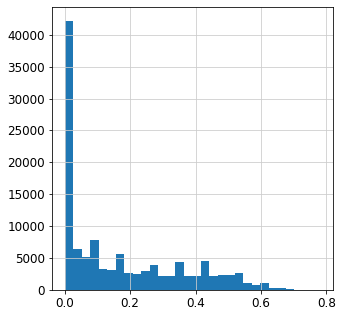

In [66]:
#plot uncertainty distribution
plt.hist(LI_uncert['fine_predicted_labels_uncertainty'], bins=30)

In [90]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(LI_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5200127722334565


(array([1687.,  403.,  379.,  661.,  321.,  332.,  282.,  672.,  327.,
         308.,  328.,  702.,  332.,  342.,  671.,  374.,  404.,  354.,
         774.,  357.,  314.,  258.,  352.,  126.,  115.,   83.,   78.,
          13.,    7.,    6.]),
 array([0.        , 0.02533725, 0.05067449, 0.07601174, 0.10134898,
        0.12668623, 0.15202347, 0.17736072, 0.20269796, 0.22803521,
        0.25337246, 0.2787097 , 0.30404695, 0.32938419, 0.35472144,
        0.38005868, 0.40539593, 0.43073318, 0.45607042, 0.48140767,
        0.50674491, 0.53208216, 0.5574194 , 0.58275665, 0.60809389,
        0.63343114, 0.65876839, 0.68410563, 0.70944288, 0.73478012,
        0.76011737]),
 <BarContainer object of 30 artists>)

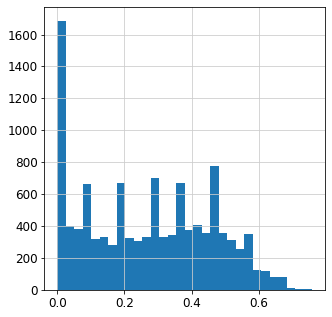

In [91]:
#plot uncertainty distribution
plt.hist(LI_cancer['fine_predicted_labels_uncertainty'], bins=30)

In [92]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(LI_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.4599415282007799


(array([4.0551e+04, 5.9730e+03, 4.7240e+03, 7.0950e+03, 2.9760e+03,
        2.7170e+03, 4.9600e+03, 2.2230e+03, 2.1490e+03, 2.5470e+03,
        3.3350e+03, 1.8740e+03, 1.9040e+03, 3.6290e+03, 1.8040e+03,
        1.8670e+03, 3.7050e+03, 1.8450e+03, 1.9380e+03, 1.9070e+03,
        2.0620e+03, 8.2400e+02, 6.6900e+02, 8.8500e+02, 2.4300e+02,
        1.6200e+02, 1.4600e+02, 1.4000e+01, 1.0000e+01, 3.0000e+00]),
 array([0.        , 0.02599722, 0.05199445, 0.07799167, 0.1039889 ,
        0.12998612, 0.15598334, 0.18198057, 0.20797779, 0.23397502,
        0.25997224, 0.28596946, 0.31196669, 0.33796391, 0.36396114,
        0.38995836, 0.41595558, 0.44195281, 0.46795003, 0.49394725,
        0.51994448, 0.5459417 , 0.57193893, 0.59793615, 0.62393337,
        0.6499306 , 0.67592782, 0.70192505, 0.72792227, 0.75391949,
        0.77991672]),
 <BarContainer object of 30 artists>)

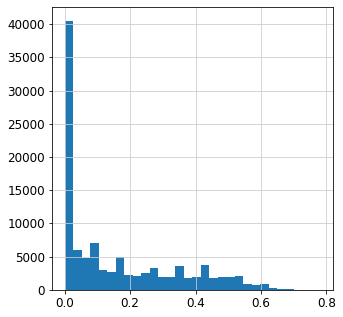

In [93]:
#plot uncertainty distribution
plt.hist(LI_other['fine_predicted_labels_uncertainty'], bins=30)

In [131]:
B_uncert = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_B_20230226.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (73,82,83,84,86,93,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [132]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(B_uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.37998234629631045


(array([2.8830e+04, 1.2142e+04, 9.6530e+03, 7.7610e+03, 1.1421e+04,
        4.0730e+03, 3.4040e+03, 2.7510e+03, 4.6680e+03, 1.9540e+03,
        1.7160e+03, 1.6230e+03, 2.9840e+03, 1.3120e+03, 1.3680e+03,
        1.3120e+03, 1.1470e+03, 2.4290e+03, 1.2120e+03, 1.1570e+03,
        1.0550e+03, 1.2300e+03, 4.2500e+02, 2.9300e+02, 1.9500e+02,
        2.5200e+02, 5.7000e+01, 2.3000e+01, 1.7000e+01, 8.0000e+00]),
 array([0.        , 0.02466654, 0.04933308, 0.07399962, 0.09866616,
        0.1233327 , 0.14799924, 0.17266578, 0.19733232, 0.22199886,
        0.2466654 , 0.27133194, 0.29599848, 0.32066502, 0.34533156,
        0.3699981 , 0.39466464, 0.41933118, 0.44399772, 0.46866426,
        0.4933308 , 0.51799734, 0.54266388, 0.56733042, 0.59199696,
        0.6166635 , 0.64133004, 0.66599658, 0.69066312, 0.71532966,
        0.73999619]),
 <BarContainer object of 30 artists>)

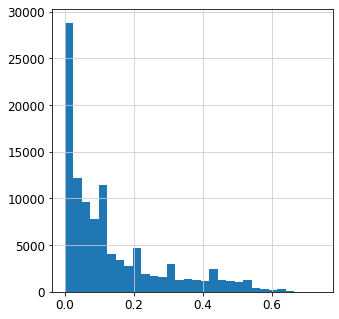

In [133]:
#plot uncertainty distribution
plt.hist(B_uncert['fine_predicted_labels_uncertainty'], bins=30)

In [134]:
B_uncert['disease'] = B_uncert['donor_category'].astype(str) + '_' + B_uncert['donor_disease'].astype(str)

In [135]:
B_uncert['disease'].unique()

array(['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD'],
      dtype=object)

In [136]:
B_cancer = B_uncert[B_uncert['disease'].isin(['disease_cancer'])]
B_other = B_uncert[~B_uncert['disease'].isin(['disease_cancer'])]

In [137]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(B_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.35999794602394103


In [138]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(B_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.38000314831733706


In [76]:
stomach = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Epi_stomach_method2_20230226.csv',index_col=0)

In [77]:
stomach

latent_cell_probability  latent_RT_efficiency  \
index                                                                        
AAACCTGGTTCCACGG-GSM5101014                 0.999850              1.026135   
AAACCTGTCACGCGGT-GSM5101014                 0.999951              1.635007   
AAACCTGTCCAATGGT-GSM5101014                 0.999979              1.445156   
AAACCTGTCCCTAACC-GSM5101014                 0.999971              1.577106   
AAACGGGAGAGTACCG-GSM5101014                 0.998578              0.727382   
...                                              ...                   ...   
TTTGCGCTCAGGATCT-GSM4546346                 0.999774              1.340966   
TTTGGTTAGTGACTCT-GSM4546346                 0.999709              1.162290   
TTTGGTTCAAACTGTC-GSM4546346                 0.999884              1.969957   
TTTGGTTCAGCGTAAG-GSM4546346                 0.999862              1.428681   
TTTGGTTTCAGGTTCA-GSM4546346                 0.999940              2.888317   

                              cecilia22_predH  cecilia22_predH_prob  \
index                                                                 
AAACCTGGTTCCACGG-GSM5101014           T cells              0.064910   
AAACCTGTCACGCGGT-GSM5101014  Epithelial cells              0.992968   
AAACCTGTCCAATGGT-GSM5101014  Epithelial cells              0.997977   
AAACCTGTCCCTAACC-GSM5101014  Epithelial cells              0.602373   
AAACGGGAGAGTACCG-GSM5101014           T cells              0.821998   
...                                       ...                   ...   
TTTGCGCTCAGGATCT-GSM4546346      Plasma cells              0.896203   
TTTGGTTAGTGACTCT-GSM4546346      Plasma cells              0.162929   
TTTGGTTCAAACTGTC-GSM4546346  Epithelial cells              0.001299   
TTTGGTTCAGCGTAAG-GSM4546346      Plasma cells              0.708003   
TTTGGTTTCAGGTTCA-GSM4546346  Epithelial cells              0.025135   

                            cecilia22_predH_uncertain  \
index                                                   
AAACCTGGTTCCACGG-GSM5101014                 Uncertain   
AAACCTGTCACGCGGT-GSM5101014          Epithelial cells   
AAACCTGTCCAATGGT-GSM5101014          Epithelial cells   
AAACCTGTCCCTAACC-GSM5101014          Epithelial cells   
AAACGGGAGAGTACCG-GSM5101014                   T cells   
...                                               ...   
TTTGCGCTCAGGATCT-GSM4546346              Plasma cells   
TTTGGTTAGTGACTCT-GSM4546346                 Uncertain   
TTTGGTTCAAACTGTC-GSM4546346                 Uncertain   
TTTGGTTCAGCGTAAG-GSM4546346              Plasma cells   
TTTGGTTTCAGGTTCA-GSM4546346                 Uncertain   

                                      cecilia22_predL  cecilia22_predL_prob  \
index                                                                         
AAACCTGGTTCCACGG-GSM5101014  Tcm/Naive helper T cells              0.080985   
AAACCTGTCACGCGGT-GSM5101014          Epithelial cells              0.997998   
AAACCTGTCCAATGGT-GSM5101014          Epithelial cells              0.998869   
AAACCTGTCCCTAACC-GSM5101014          Epithelial cells              0.560122   
AAACGGGAGAGTACCG-GSM5101014  Tcm/Naive helper T cells              0.055553   
...                                               ...                   ...   
TTTGCGCTCAGGATCT-GSM4546346          Epithelial cells              0.578191   
TTTGGTTAGTGACTCT-GSM4546346              Plasma cells              0.016857   
TTTGGTTCAAACTGTC-GSM4546346          Epithelial cells              0.000933   
TTTGGTTCAGCGTAAG-GSM4546346              Plasma cells              0.246943   
TTTGGTTTCAGGTTCA-GSM4546346          Epithelial cells              0.095139   

                            cecilia22_predL_uncertain elmentaite21_pred  \
index                                                                     
AAACCTGGTTCCACGG-GSM5101014                 Uncertain                TA   
AAACCTGTCACGCGGT-GSM5101014          Epithelial cells    Microfold cell   
AAACCTGTCCAATGGT-GSM

In [78]:
stomach['disease'] = stomach['donor_category'].astype(str) + '_' + stomach['donor_disease'].astype(str)

In [80]:
stomach['disease'].unique()

array(['disease_cancer'], dtype=object)

In [81]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(stomach['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.480283260345459


(array([9.796e+03, 1.638e+03, 1.229e+03, 1.992e+03, 7.960e+02, 7.330e+02,
        1.431e+03, 6.160e+02, 6.190e+02, 9.410e+02, 8.430e+02, 5.640e+02,
        5.880e+02, 1.127e+03, 5.670e+02, 5.350e+02, 1.243e+03, 6.060e+02,
        5.880e+02, 8.020e+02, 6.230e+02, 3.560e+02, 2.680e+02, 4.490e+02,
        1.710e+02, 1.000e+02, 1.120e+02, 3.200e+01, 1.200e+01, 4.000e+00]),
 array([0.        , 0.02599945, 0.0519989 , 0.07799835, 0.1039978 ,
        0.12999725, 0.1559967 , 0.18199615, 0.2079956 , 0.23399505,
        0.2599945 , 0.28599395, 0.3119934 , 0.33799285, 0.3639923 ,
        0.38999175, 0.4159912 , 0.44199064, 0.46799009, 0.49398954,
        0.51998899, 0.54598844, 0.57198789, 0.59798734, 0.62398679,
        0.64998624, 0.67598569, 0.70198514, 0.72798459, 0.75398404,
        0.77998349]),
 <BarContainer object of 30 artists>)

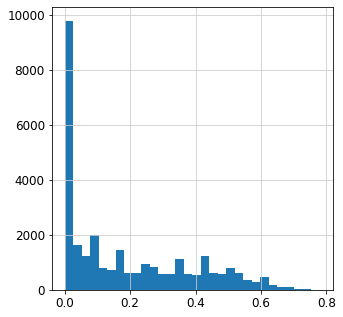

In [82]:
#plot uncertainty distribution
plt.hist(stomach['fine_predicted_labels_uncertainty'], bins=30)

In [97]:
T_uncert = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_TNK_20230226.csv')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (82,83,84,86,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [98]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(T_uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5200046300888062


(array([2.4054e+04, 5.4920e+03, 8.0160e+03, 3.2290e+03, 5.4750e+03,
        2.3590e+03, 4.3310e+03, 2.0410e+03, 1.9330e+03, 3.6290e+03,
        1.7250e+03, 3.4670e+03, 1.6770e+03, 3.3890e+03, 1.6950e+03,
        1.7030e+03, 3.4920e+03, 1.7660e+03, 2.9000e+03, 1.2630e+03,
        2.1220e+03, 8.9000e+02, 7.8200e+02, 1.1400e+03, 3.7800e+02,
        4.1900e+02, 1.0500e+02, 5.9000e+01, 5.0000e+00, 1.0000e+00]),
 array([0.        , 0.02866588, 0.05733176, 0.08599765, 0.11466353,
        0.14332941, 0.17199529, 0.20066117, 0.22932705, 0.25799294,
        0.28665882, 0.3153247 , 0.34399058, 0.37265646, 0.40132235,
        0.42998823, 0.45865411, 0.48731999, 0.51598587, 0.54465176,
        0.57331764, 0.60198352, 0.6306494 , 0.65931528, 0.68798116,
        0.71664705, 0.74531293, 0.77397881, 0.80264469, 0.83131057,
        0.85997646]),
 <BarContainer object of 30 artists>)

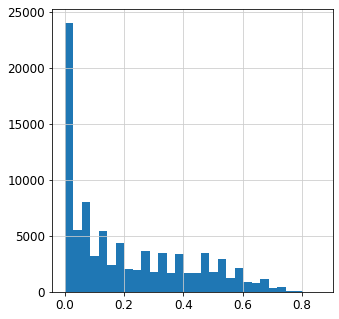

In [99]:
#plot uncertainty distribution
plt.hist(T_uncert['fine_predicted_labels_uncertainty'], bins=30)

In [100]:
T_uncert['disease'] = T_uncert['donor_category'].astype(str) + '_' + T_uncert['donor_disease'].astype(str)

In [101]:
T_uncert['disease'].unique()

array(['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD'],
      dtype=object)

In [102]:
T_cancer = T_uncert[T_uncert['disease'].isin(['disease_cancer'])]
T_other = T_uncert[~T_uncert['disease'].isin(['disease_cancer'])]

In [103]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(T_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5200107097625732


In [104]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(T_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5200030237436295


In [107]:
Mes_uncert = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Mes_20230226.csv')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (84,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [108]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Mes_uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5000855147838592


(array([6087., 1127.,  832., 1269.,  501.,  518.,  864.,  351.,  413.,
         692.,  378.,  333.,  356.,  690.,  356.,  349.,  771.,  356.,
         419.,  656.,  325.,  271.,  217.,  375.,  135.,  102.,  115.,
          20.,   15.,   10.]),
 array([0.        , 0.02600438, 0.05200876, 0.07801313, 0.10401751,
        0.13002189, 0.15602627, 0.18203065, 0.20803502, 0.2340394 ,
        0.26004378, 0.28604816, 0.31205254, 0.33805691, 0.36406129,
        0.39006567, 0.41607005, 0.44207443, 0.4680788 , 0.49408318,
        0.52008756, 0.54609194, 0.57209632, 0.59810069, 0.62410507,
        0.65010945, 0.67611383, 0.70211821, 0.72812258, 0.75412696,
        0.78013134]),
 <BarContainer object of 30 artists>)

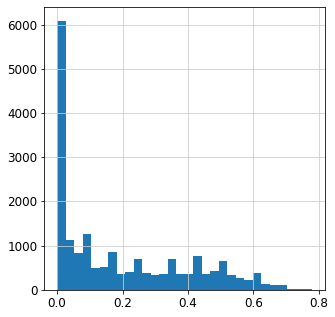

In [109]:
#plot uncertainty distribution
plt.hist(Mes_uncert['fine_predicted_labels_uncertainty'], bins=30)

In [110]:
Mes_uncert['disease'] = Mes_uncert['donor_category'].astype(str) + '_' + Mes_uncert['donor_disease'].astype(str)

In [111]:
Mes_uncert['disease'].unique()

array(['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD'],
      dtype=object)

In [113]:
Mes_cancer = Mes_uncert[Mes_uncert['disease'].isin(['disease_cancer'])]
Mes_other = Mes_uncert[~Mes_uncert['disease'].isin(['disease_cancer'])]

In [114]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Mes_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.519984346628189


In [115]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Mes_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.500009149312973


In [116]:
Mye_uncert = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Myeloid_20230226.csv')

In [117]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Mye_uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5199918448925018


In [118]:
Mye_uncert['disease'] = Mye_uncert['donor_category'].astype(str) + '_' + Mye_uncert['donor_disease'].astype(str)

In [119]:
Mye_uncert['disease'].unique()

array(['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD'],
      dtype=object)

In [120]:
Mye_cancer = Mye_uncert[Mye_uncert['disease'].isin(['disease_cancer'])]
Mye_other = Mye_uncert[~Mye_uncert['disease'].isin(['disease_cancer'])]

In [121]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Mye_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5200206905603408


In [122]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Mye_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5000235676765442


In [124]:
Neural = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Neural_20230226.csv',index_col=0)

In [125]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Neural['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.6000240206718445


In [126]:
Neural['disease'] = Neural['donor_category'].astype(str) + '_' + Neural['donor_disease'].astype(str)

In [127]:
Neural['disease'].unique()

array(['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD'],
      dtype=object)

In [128]:
Neural_cancer = Neural[Neural['disease'].isin(['disease_cancer'])]
Neural_other = Neural[~Neural['disease'].isin(['disease_cancer'])]

In [129]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Neural_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5800342977046966


In [130]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Neural_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.6000827670097351


In [139]:
Endo = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Endo_20230226.csv',index_col=0)

In [140]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Endo['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.4599775671958923


In [141]:
Endo['disease'] = Endo['donor_category'].astype(str) + '_' + Endo['donor_disease'].astype(str)

In [142]:
Endo['disease'].unique()

array(['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD'],
      dtype=object)

In [143]:
Endo_cancer = Endo[Endo['disease'].isin(['disease_cancer'])]
Endo_other = Endo[~Endo['disease'].isin(['disease_cancer'])]

In [146]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Endo_cancer['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.45990816354751585


In [147]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(Endo_other['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.45999362468719485


### Conclusion:
- should use cut offs per lineage for classifying cells as unknown
- for epithelium calculate cut off for cancer and other diseases separately due to presence of cancer cells

### Continue with annotating small intestine epithelial cells

In [149]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(uncert['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.379987895488739


In [151]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-151-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [152]:
#mark cells are unknown based on cut off of 90th percentile
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.38, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [156]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.remove_categories('Uncertain (> 0.3)')

<ipython-input-156-4aaacebe2ddd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.remove_categories('Uncertain (> 0.3)')


In [157]:
uncert['fine_predicted_labels'].value_counts()

Enterocyte           80137
TA_cycling           33722
Unknown              16383
Goblet                8421
Goblet_progenitor     5902
Doublets              5514
Goblet_cycling        3900
Paneth                3369
Epithelial_stem       3343
Enteroendocrine       1794
Tuft                  1723
BEST4                 1071
MUC5AC                 249
Microfold              134
MUC6                   131
Name: fine_predicted_labels, dtype: int64

In [158]:
adata.obs['fine_predicted_labels_uncertflagged'] = uncert['fine_predicted_labels']

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


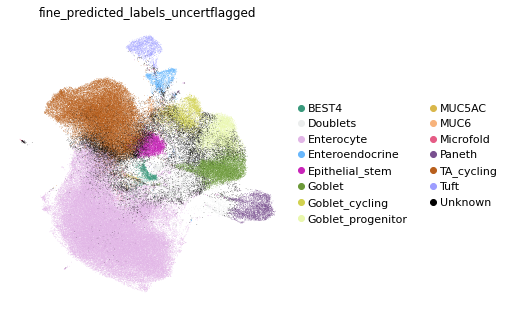

In [159]:
sc.pl.umap(adata,color=['fine_predicted_labels_uncertflagged'], palette=['#39997c',#BEST4
                                                 
                                               
                                                 '#ebeded',#doublets
                                               '#e1b5e6',#enterocyte
                                                '#68b7fc',#enteroendocrine
                                               '#c924b9',#stem
                                               '#6c9939',#goblet
                                               '#d1d14f',#goblet_cycling
                                               '#e9f7ad',#goblet progenitor
                                               
                                               
                                              '#d9b74a',#MUC5AC
                                               '#f7b37c',#MUC6
                                               
                                               '#e55b85',#Microfold
                                               '#79508f',#paneth
                                              #'#ad1a55',#TA
                                               '#b85f1c',#TA cycling
                                               '#9d9dff',#tuft
                                                '#000000',#unknown
                                                                         
                                               
                                               
    
    
                                              ],size=1.2)

In [160]:
adata.obs.disease.cat.categories

Index(['control', 'crohns_disease', 'pediatric_IBD', 'celiac_active',
       'celiac_treated'],
      dtype='object')

In [161]:
adata.obs['disease'].cat.reorder_categories(['control',
 'crohns_disease',
 'pediatric_IBD','celiac_active','celiac_treated'], inplace=True)

<ipython-input-161-912bdeba3687>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['disease'].cat.reorder_categories(['control',


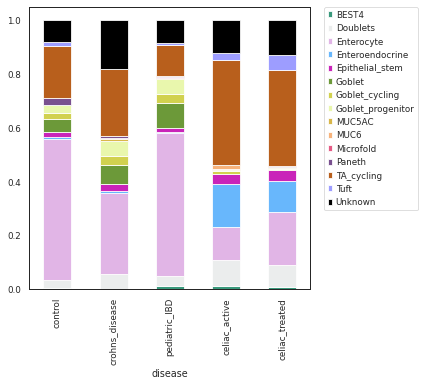

In [165]:
tmp = pd.crosstab(adata.obs['disease'], adata.obs['fine_predicted_labels_uncertflagged'],normalize='index'
                                                                         )
tmp.plot.bar(stacked=True,color=['#39997c',#BEST4
                                                 
                                               
                                                 '#ebeded',#doublets
                                               '#e1b5e6',#enterocyte
                                                '#68b7fc',#enteroendocrine
                                               '#c924b9',#stem
                                               '#6c9939',#goblet
                                               '#d1d14f',#goblet_cycling
                                               '#e9f7ad',#goblet progenitor
                                               
                                               
                                              '#d9b74a',#MUC5AC
                                               '#f7b37c',#MUC6
                                               
                                               '#e55b85',#Microfold
                                               '#79508f',#paneth
                                              #'#ad1a55',#TA
                                               '#b85f1c',#TA cycling
                                               '#9d9dff',#tuft
                                                '#000000',#unknown
                                                                         ]).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('/home/jovyan/ao15/Megagut/Annotations_v3/disease_annot/figures/epi_SI_unknown_disease_distribution_bar.png')

### Finalise annotations
- calculate leiden clusters
- inspect annotations across leiden clusters
- assess marker genes, doublet markers, donor distribution
- relabel based on majority voting of leiden clusters, along with confirmation from marker genes etc.

In [170]:
#reassign labels for unknown cells by leiden clustering and majority voting
sc.tl.leiden(adata,resolution=1,key_added='leiden1')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


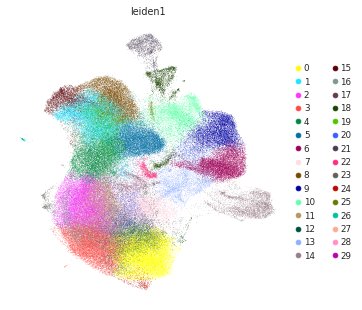

In [171]:
sc.pl.umap(adata,color='leiden1')

In [172]:
pd.crosstab(adata.obs.leiden1,adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  BEST4  Doublets  Enterocyte  \
leiden1                                                            
0                                        0         3       16664   
1                                        0       758         102   
2                                        0        15       13647   
3                                        0        15       13251   
4                                        6        64        5676   
5                                        5       119          17   
6                                        0         1          32   
7                                        0       285        7465   
8                                        0        21           1   
9                                        0       174           1   
10                                       0       508          23   
11                                       0         2        7001   
12                                       0         8        5952   
13                                       0      2015         702   
14                                       0       623          23   
15                                       1         1           7   
16                                       0         0        3439   
17                                       2        18        2452   
18                                       0       624         295   
19                                       0        18          59   
20                                       0       229        2198   
21                                       0         2           3   
22                                    1057         2          50   
23                                       0         0         483   
24                                       0         0         521   
25                                       0         6           2   
26                                       0         0           6   
27                                       0         3          33   
28                                       0         0          23   
29                                       0         0           9   

fine_predicted_labels_uncertflagged  Enteroendocrine  Epithelial_stem  Goblet  \
leiden1                                                                         
0                                                  0                0       0   
1                                                  0                0       0   
2                                                  0                0       0   
3                                                  0                0       0   
4                                                  0                0       0   
5                                                  0             3287       0   
6                                                  0                0    7765   
7                                                  0                1       0   
8                                                  0                1       0   
9                                                  0                1     223   
10                                                 0                5       1   
11                                                 0                0       0   
12                                                 0                0       0   
13                                                 0                0     383   
14                                                 0               13       1   
15                                                 0                0       0   
16                                                 0                0       0   
17                                                 0                0      28   
18                                              1794               12      20   
19                                                 0                1       0   
20                                       

In [173]:
#reassign labels for unknown cells by leiden clustering and majority voting
sc.tl.leiden(adata,resolution=0.5,key_added='leiden0.5')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


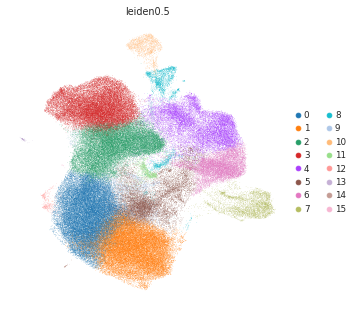

In [174]:
sc.pl.umap(adata,color='leiden0.5')

In [176]:
pd.crosstab(adata.obs['leiden0.5'],adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  BEST4  Doublets  Enterocyte  \
leiden0.5                                                          
0                                        1        24       32739   
1                                        0         7       32129   
2                                       12       507        5327   
3                                        1       199           1   
4                                        0       838          35   
5                                        0      2588        7622   
6                                        0        86          82   
7                                        0       620          23   
8                                        0       616         215   
9                                        2        22        1452   
10                                       0         2           3   
11                                    1055         2          42   
12                                       0         0         419   
13                                       0         0           6   
14                                       0         3          33   
15                                       0         0           9   

fine_predicted_labels_uncertflagged  Enteroendocrine  Epithelial_stem  Goblet  \
leiden0.5                                                                       
0                                                  0                0       0   
1                                                  0                0       0   
2                                                  0             3282       0   
3                                                  0                0       0   
4                                                  0               11     263   
5                                                  0                1       6   
6                                                  0                1    8123   
7                                                  0               14       1   
8                                               1794               13       0   
9                                                  0                1      28   
10                                                 0               17       0   
11                                                 0                3       0   
12                                                 0                0       0   
13                                                 0                0       0   
14                                                 0                0       0   
15                                                 0                0       0   

fine_predicted_labels_uncertflagged  Goblet_cycling  Goblet_progenitor  \
leiden0.5                                                                
0                                                 0                  0   
1                                                 0                  0   
2                                                 1                  0   
3                                                 1                  0   
4                                              3897               5476   
5                                                 0                 58   
6                                                 0                367   
7                                                 1                  0   
8                                                 0                  1   
9                                                 0                  0   
10                                                0                  0   
11                                                0                  0   
12                                                0                  0   
13                                                0                  0   
14                                                0                  0   
15                                                0       

In [178]:
#Use Leiden resolution 1
unknown = adata.obs[['leiden1','fine_predicted_labels_uncertflagged']]

In [179]:
unknown = unknown[unknown['fine_predicted_labels_uncertflagged'].isin(['Unknown'])]

In [180]:
unknown

leiden1  \
index                                              
AAAGTAGAGAATGTTG-4918STDY7273964              10   
AAAGTAGAGTCCAGGA-4918STDY7273964               9   
AACACGTCACGGATAG-4918STDY7273964               4   
AACCATGAGTTTCCTT-4918STDY7273964               9   
AACCATGGTCGGGTCT-4918STDY7273964               5   
...                                          ...   
TCCCGATCACAGGTTT-1_16-GI4401_DUO_EPI_GEX       5   
TCTGAGAAGTTTCCTT-1_16-GI4401_DUO_EPI_GEX      19   
TGCACCTCACGTTGGC-1_16-GI4401_DUO_EPI_GEX      25   
TTCTACATCAGCATGT-1_16-GI4401_DUO_EPI_GEX       1   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX      18   

                                         fine_predicted_labels_uncertflagged  
index                                                                         
AAAGTAGAGAATGTTG-4918STDY7273964                                     Unknown  
AAAGTAGAGTCCAGGA-4918STDY7273964                                     Unknown  
AACACGTCACGGATAG-4918STDY7273964                                     Unknown  
AACCATGAGTTTCCTT-4918STDY7273964                                     Unknown  
AACCATGGTCGGGTCT-4918STDY7273964                                     Unknown  
...                                                                      ...  
TCCCGATCACAGGTTT-1_16-GI4401_DUO_EPI_GEX                             Unknown  
TCTGAGAAGTTTCCTT-1_16-GI4401_DUO_EPI_GEX                             Unknown  
TGCACCTCACGTTGGC-1_16-GI4401_DUO_EPI_GEX                             Unknown  
TTCTACATCAGCATGT-1_16-GI4401_DUO_EPI_GEX                             Unknown  
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                             Unknown  

[16383 rows x 2 columns]

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


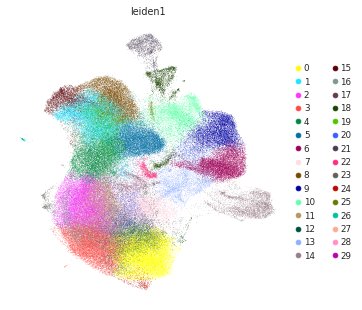

In [182]:
sc.pl.umap(adata,color='leiden1')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


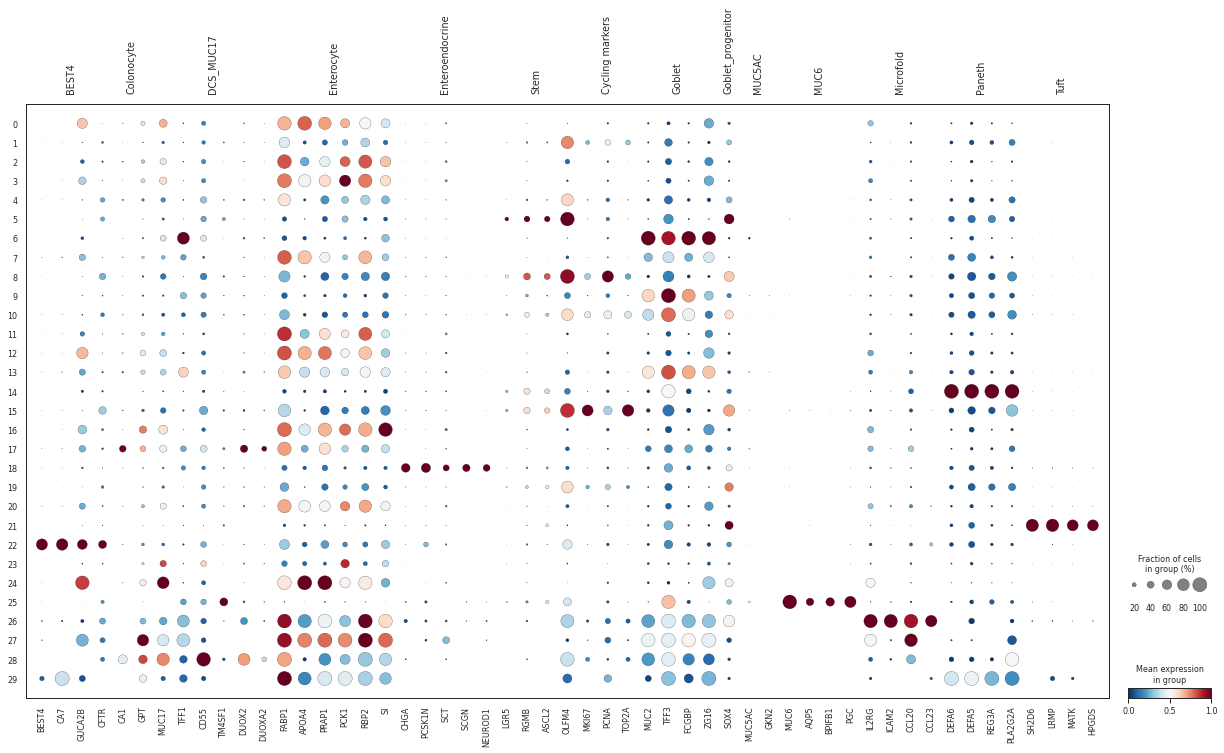

In [183]:
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='leiden1',color_map='RdBu_r', standard_scale='var')

In [181]:
pd.crosstab(adata.obs.leiden1,adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  BEST4  Doublets  Enterocyte  \
leiden1                                                            
0                                        0         3       16664   
1                                        0       758         102   
2                                        0        15       13647   
3                                        0        15       13251   
4                                        6        64        5676   
5                                        5       119          17   
6                                        0         1          32   
7                                        0       285        7465   
8                                        0        21           1   
9                                        0       174           1   
10                                       0       508          23   
11                                       0         2        7001   
12                                       0         8        5952   
13                                       0      2015         702   
14                                       0       623          23   
15                                       1         1           7   
16                                       0         0        3439   
17                                       2        18        2452   
18                                       0       624         295   
19                                       0        18          59   
20                                       0       229        2198   
21                                       0         2           3   
22                                    1057         2          50   
23                                       0         0         483   
24                                       0         0         521   
25                                       0         6           2   
26                                       0         0           6   
27                                       0         3          33   
28                                       0         0          23   
29                                       0         0           9   

fine_predicted_labels_uncertflagged  Enteroendocrine  Epithelial_stem  Goblet  \
leiden1                                                                         
0                                                  0                0       0   
1                                                  0                0       0   
2                                                  0                0       0   
3                                                  0                0       0   
4                                                  0                0       0   
5                                                  0             3287       0   
6                                                  0                0    7765   
7                                                  0                1       0   
8                                                  0                1       0   
9                                                  0                1     223   
10                                                 0                5       1   
11                                                 0                0       0   
12                                                 0                0       0   
13                                                 0                0     383   
14                                                 0               13       1   
15                                                 0                0       0   
16                                                 0                0       0   
17                                                 0                0      28   
18                                              1794               12      20   
19                                                 0                1       0   
20                                       

In [185]:
unknown_adata = adata[adata.obs['fine_predicted_labels_uncertflagged'].isin(['Unknown'])].copy()

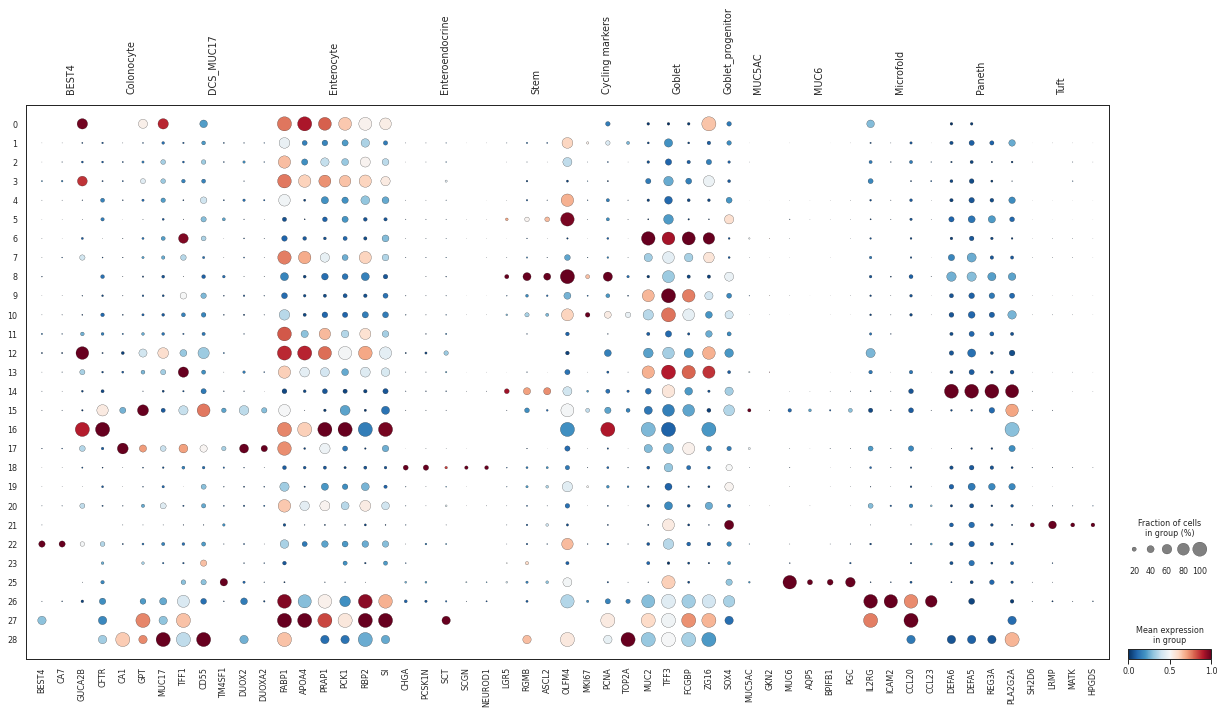

In [186]:
sc.pl.dotplot(unknown_adata,var_names=marker_genes_dict,groupby='leiden1',color_map='RdBu_r', standard_scale='var')

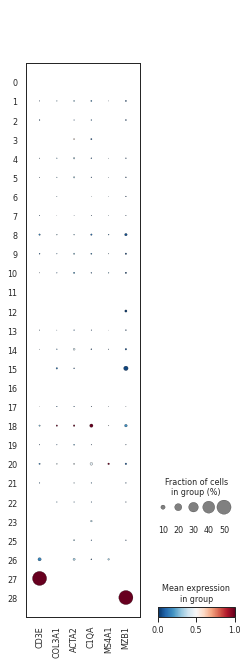

In [188]:
#plot some doublet markers
sc.pl.dotplot(unknown_adata,var_names=['CD3E','COL3A1','ACTA2','C1QA','MS4A1','MZB1'],groupby='leiden1',color_map='RdBu_r', standard_scale='var')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


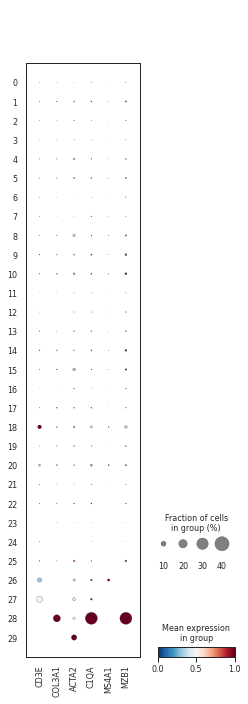

In [194]:
#plot some doublet markers
sc.pl.dotplot(adata,var_names=['CD3E','COL3A1','ACTA2','C1QA','MS4A1','MZB1'],groupby='leiden1',color_map='RdBu_r', standard_scale='var')

In [190]:
adata

AnnData object with n_obs × n_vars = 165793 × 18485
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


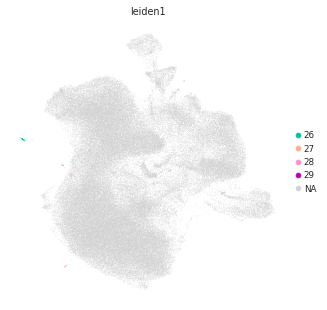

In [189]:
sc.pl.umap(adata,color='leiden1',groups=['26','27','28','29'])

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


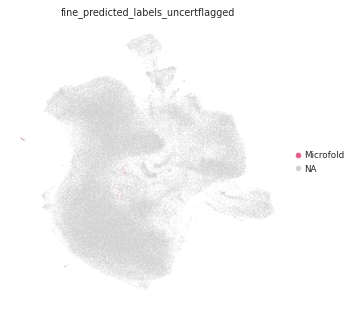

In [193]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',groups=['Microfold'])

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


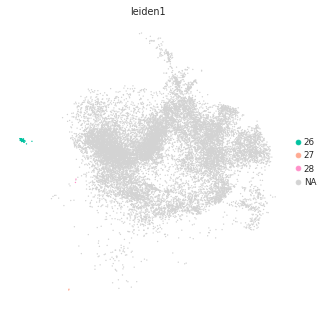

In [191]:
sc.pl.umap(unknown_adata,color='leiden1',groups=['26','27','28','29'])

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


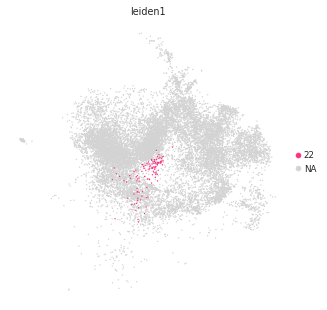

In [209]:
sc.pl.umap(unknown_adata,color='leiden1',groups=['22'])

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


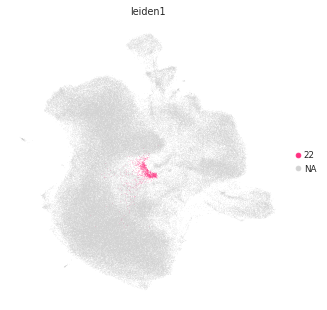

In [210]:
sc.pl.umap(adata,color='leiden1',groups=['22'])

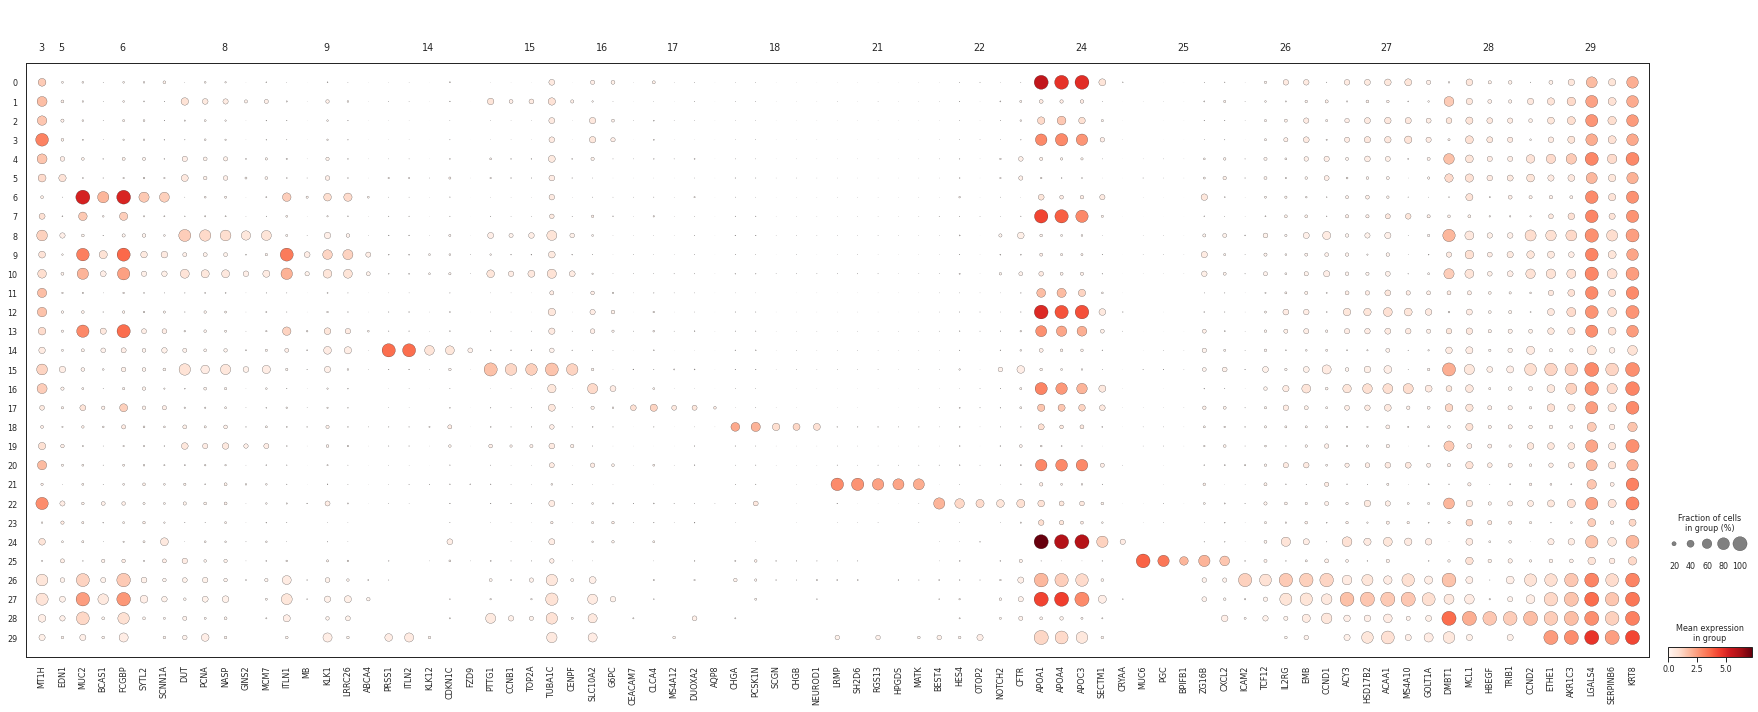

In [248]:
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="leiden1")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='leiden1', mks=mks)

In [220]:
unknown['fine_predicted_labels_resolved'] = (unknown['leiden1']
        .map(lambda x:{'0':'Enterocyte',
                       '1':'TA_cycling',
                       '2':'Enterocyte',
                       '3':'Enterocyte',
                       '4':'Enterocyte',
                       '5':'TA_cycling', #split between stem and TA_cycling but lower LGR5 expression
                       '6':'Goblet',
                       '7':'Enterocyte',
                       '8':'Epithelial_stem', #majority voting of cluster says TA_cyling, but these cells have high LGR5?
                       '9':'Goblet_progenitor',
                       '10':'Goblet_cycling',
                       '11':'Enterocyte',
                       '12':'Enterocyte',
                       '13':'Doublets',
                       '14':'Paneth',
                       '15':'TA_cycling',
                       '16':'Enterocyte',
                       '17':'Enterocyte',
                       '18':'Enteroendocrine',
                       '19':'TA_cycling',
                       '20':'Enterocyte',
                       '21':'Tuft',
                       '22':'BEST4',
                       '23':'Enterocyte',
                       #'24':'', --> no unknown cells in this leiden cluster
                       '25':'MUC6',
                       '26':'Microfold',
                       '27':'Doublets', #--> T cell doublets?
                       '28':'Doublets', #--> B cell doublets?
                       #'29':'', --> no unknown cells in this leiden cluster
                         }.get(x,x)).astype('category'))

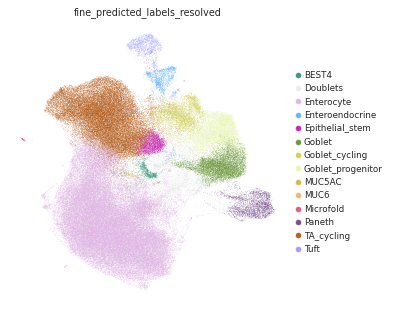

In [221]:
ON = {O:N for O,N in zip(unknown.index,unknown["fine_predicted_labels_resolved"])}
adata.obs["fine_predicted_labels_resolved"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_resolved')

In [222]:
adata.obs['fine_predicted_labels_uncertflagged'].value_counts()

Enterocyte           80137
TA_cycling           33722
Unknown              16383
Goblet                8421
Goblet_progenitor     5902
Doublets              5514
Goblet_cycling        3900
Paneth                3369
Epithelial_stem       3343
Enteroendocrine       1794
Tuft                  1723
BEST4                 1071
MUC5AC                 249
Microfold              134
MUC6                   131
Name: fine_predicted_labels_uncertflagged, dtype: int64

In [223]:
adata.obs['fine_predicted_labels_resolved'].value_counts()

Enterocyte           84159
TA_cycling           38448
Goblet                9149
Goblet_progenitor     7614
Doublets              7458
Goblet_cycling        5916
Paneth                3649
Epithelial_stem       3423
Enteroendocrine       2289
Tuft                  1820
BEST4                 1188
MUC5AC                 249
MUC6                   226
Microfold              205
Name: fine_predicted_labels_resolved, dtype: int64

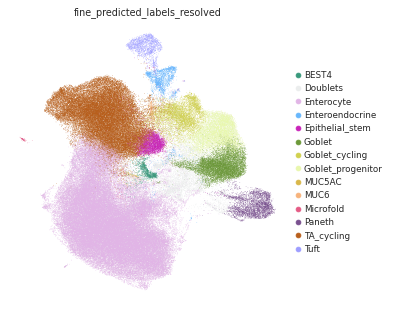

In [224]:
sc.pl.umap(adata,color=['fine_predicted_labels_resolved'], palette=['#39997c',#BEST4
                                                 
                                               
                                                 '#ebeded',#doublets
                                               '#e1b5e6',#enterocyte
                                                '#68b7fc',#enteroendocrine
                                               '#c924b9',#stem
                                               '#6c9939',#goblet
                                               '#d1d14f',#goblet_cycling
                                               '#e9f7ad',#goblet progenitor
                                               
                                               
                                              '#d9b74a',#MUC5AC
                                               '#f7b37c',#MUC6
                                               
                                               '#e55b85',#Microfold
                                               '#79508f',#paneth
                                              #'#ad1a55',#TA
                                               '#b85f1c',#TA cycling
                                               '#9d9dff',#tuft
                                                '#000000',#unknown
                                                                         
                                               
                                               
    
    
                                              ],size=1.2)

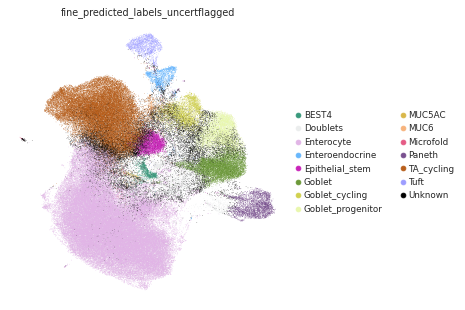

In [225]:
sc.pl.umap(adata,color=['fine_predicted_labels_uncertflagged'], palette=['#39997c',#BEST4
                                                 
                                               
                                                 '#ebeded',#doublets
                                               '#e1b5e6',#enterocyte
                                                '#68b7fc',#enteroendocrine
                                               '#c924b9',#stem
                                               '#6c9939',#goblet
                                               '#d1d14f',#goblet_cycling
                                               '#e9f7ad',#goblet progenitor
                                               
                                               
                                              '#d9b74a',#MUC5AC
                                               '#f7b37c',#MUC6
                                               
                                               '#e55b85',#Microfold
                                               '#79508f',#paneth
                                              #'#ad1a55',#TA
                                               '#b85f1c',#TA cycling
                                               '#9d9dff',#tuft
                                                '#000000',#unknown
                                                                         
                                               
                                               
    
    
                                              ],size=1.2)

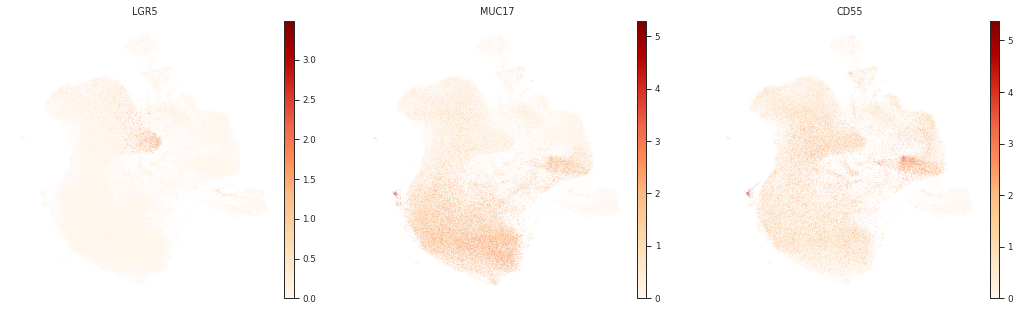

In [227]:
sc.pl.umap(adata,color=['LGR5','MUC17','CD55'],cmap='OrRd')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


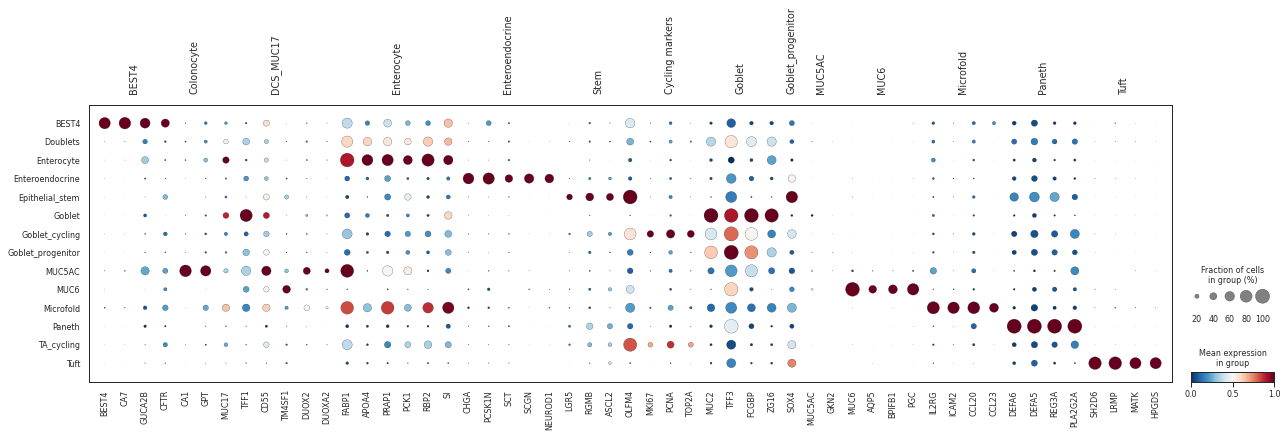

In [226]:
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var')

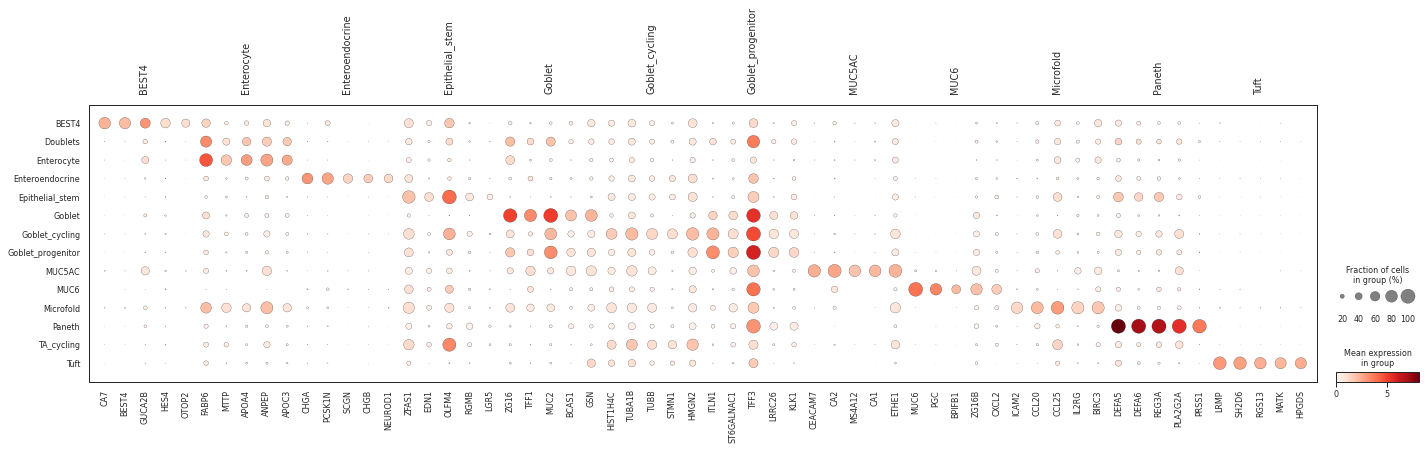

In [228]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="fine_predicted_labels_resolved")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='fine_predicted_labels_resolved', mks=mks)

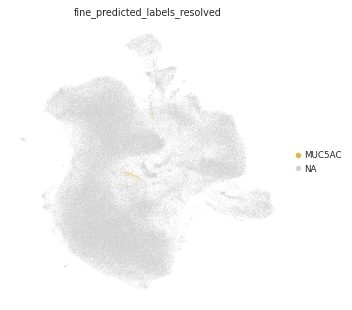

In [229]:
sc.pl.umap(adata,color='fine_predicted_labels_resolved',groups='MUC5AC')

In [230]:
MUC5AC = adata[adata.obs['fine_predicted_labels_resolved'].isin(['MUC5AC'])].copy()

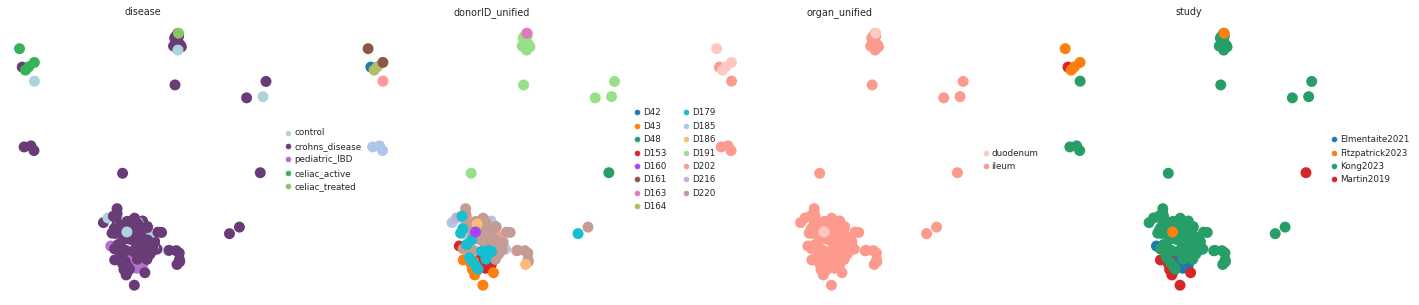

In [233]:
sc.pl.umap(MUC5AC,color=['disease','donorID_unified','organ_unified','study'])

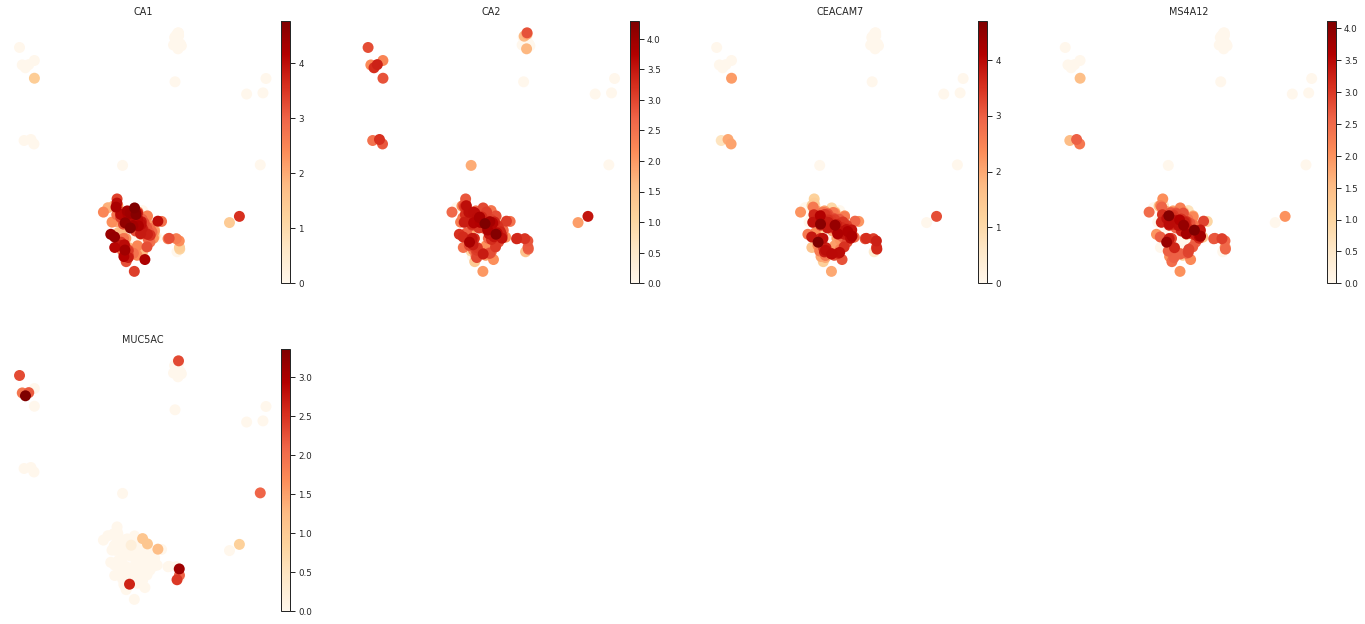

In [237]:
sc.pl.umap(MUC5AC,color=['CA1','CA2','CEACAM7','MS4A12','MUC5AC'],cmap='OrRd')

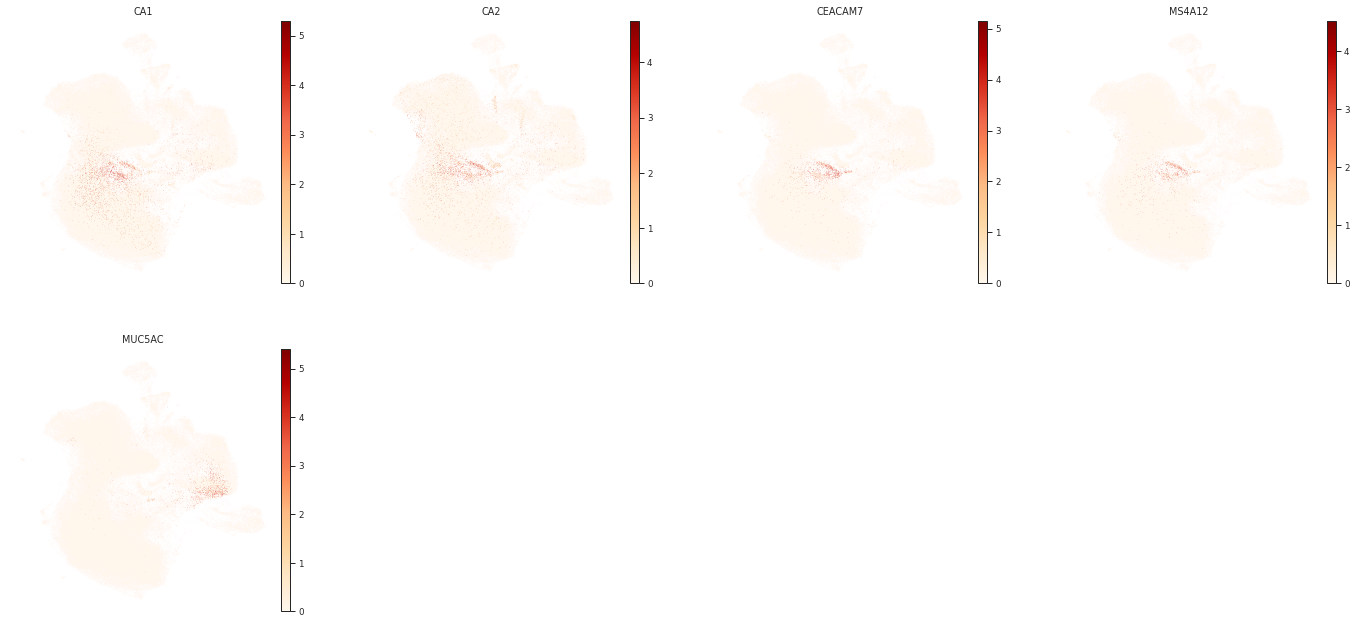

In [236]:
sc.pl.umap(adata,color=['CA1','CA2','CEACAM7','MS4A12','MUC5AC'],cmap='OrRd')

In [238]:
adata

AnnData object with n_obs × n_vars = 165793 × 18485
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

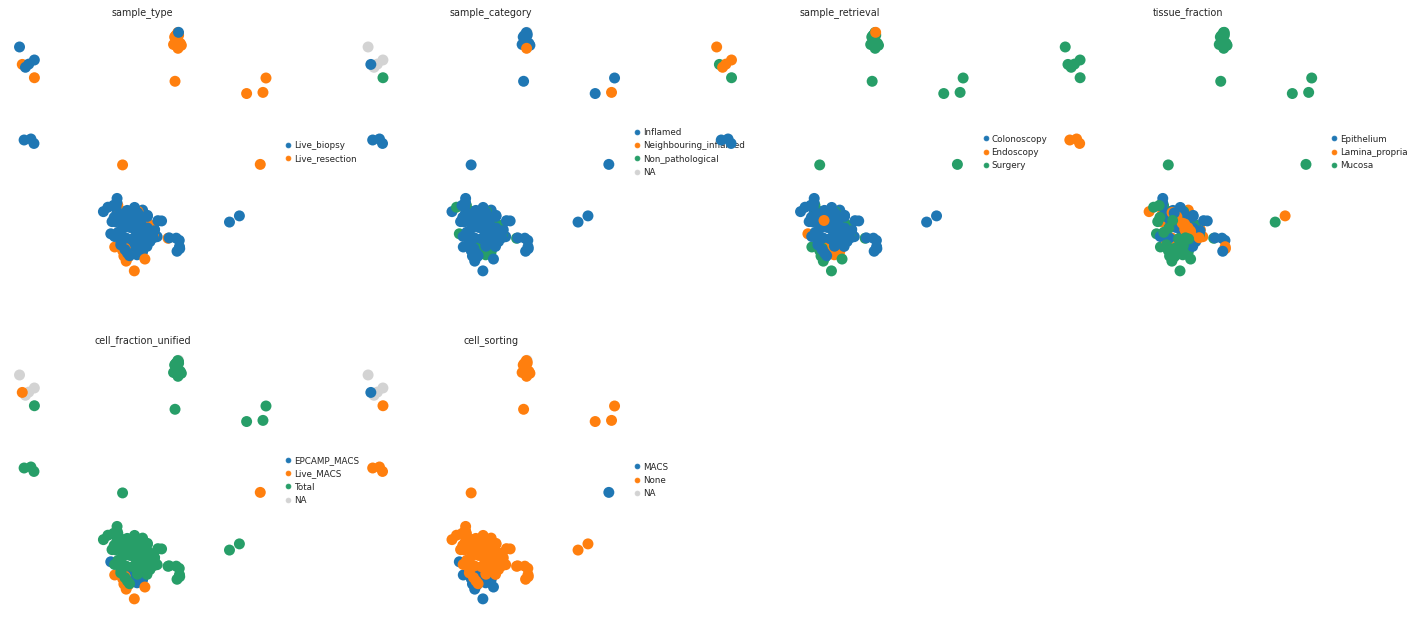

In [239]:
sc.pl.umap(MUC5AC,color=['sample_type','sample_category','sample_retrieval','tissue_fraction','cell_fraction_unified','cell_sorting'])

In [241]:
MUC5AC.obs.sample_category.value_counts()

Inflamed                 157
Non_pathological          84
Neighbouring_inflamed      2
Name: sample_category, dtype: int64

In [242]:
annot = adata.obs[['fine_predicted_labels_uncertflagged','fine_predicted_labels_resolved']]

In [243]:
annot

fine_predicted_labels_uncertflagged  \
index                                                                          
AAAGATGAGTCCAGGA-4918STDY7273964                              Goblet_cycling   
AAAGATGTCTAACTTC-4918STDY7273964                                  TA_cycling   
AAAGCAATCTTGTCAT-4918STDY7273964                                  TA_cycling   
AAAGTAGAGAATGTTG-4918STDY7273964                                     Unknown   
AAAGTAGAGTCCAGGA-4918STDY7273964                                     Unknown   
...                                                                      ...   
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                     Enteroendocrine   
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX                          Enterocyte   
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                             Unknown   
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX                          Enterocyte   
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX                          TA_cycling   

                                         fine_predicted_labels_resolved  
index                                                                    
AAAGATGAGTCCAGGA-4918STDY7273964                         Goblet_cycling  
AAAGATGTCTAACTTC-4918STDY7273964                             TA_cycling  
AAAGCAATCTTGTCAT-4918STDY7273964                             TA_cycling  
AAAGTAGAGAATGTTG-4918STDY7273964                         Goblet_cycling  
AAAGTAGAGTCCAGGA-4918STDY7273964                      Goblet_progenitor  
...                                                                 ...  
TTTATGCTCTTGCCGT-1_16-GI4401_DUO_EPI_GEX                Enteroendocrine  
TTTCCTCCACGCCAGT-1_16-GI4401_DUO_EPI_GEX                     Enterocyte  
TTTCCTCGTAGCGATG-1_16-GI4401_DUO_EPI_GEX                Enteroendocrine  
TTTGGTTAGAGTACCG-1_16-GI4401_DUO_EPI_GEX                     Enterocyte  
TTTGGTTTCGATGAGG-1_16-GI4401_DUO_EPI_GEX                     TA_cycling  

[165793 rows x 2 columns]

In [245]:
#export final annotations
annot.to_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/epi_SI_disease_annot.csv')